In [1]:
# library(httr)

In [26]:
github_api <- function(path,per_page,page,username = "",token = "") {
    
    if(!is.numeric(per_page)){
        stop("The per_page parameter should not be non-numerical value")
    }
    
    if(!is.numeric(page)){
        stop("The page parameter should not be non-numerical value")
    }
    
    if (per_page < 1 || per_page > 100 || per_page != round(per_page)) {
        stop("The per_page parameter should be a integer between 1 and 100 (inclusive)", call. = FALSE)
    }
    
    if (page < 1 || page != round(page)) {
        stop("The page parameter should be a positive integer", call. = FALSE)
    }
    
    query <- list(per_page=per_page,page=page)
    
    url <- httr::modify_url("https://api.github.com", path = path)
    if (username == "" || token == "") {
        response <- httr::GET(url, httr::add_headers(accept = "application/vnd.github.v3+json"), query = query)
    } else {
        response <- httr::GET(url, httr::add_headers(accept = "application/vnd.github.v3+json"), query = query, httr::authenticate(username, token))
    }
    
    
    if (httr::http_error(response)) {
        stop("GitHub API request failed", call. = FALSE)
    }
    
    if (httr::http_type(response) != "application/json") {
        stop("API did not return json", call. = FALSE)
    }
    response
}

format_response <- function(response,output_type) {
    result <- NULL
    if (output_type == "list") {
        result <- jsonlite::fromJSON(rawToChar(response$content), simplifyVector = FALSE)
    } else if (output_type == "dataframe") {
        result <- jsonlite::fromJSON(rawToChar(response$content),flatten = TRUE)
    } else if (output_type == "character") {
        result <- rawToChar(response$content)
    } else if (output_type == "raw") {
        result <- response
    } else {
        stop("Unexpected output type, possible values are: 'list', 'dataframe', 'character'")
    }
    
    result
}

In [27]:
# resp <- github_api("/events",list(per_page=1,page=0))
# resp

In [28]:
github_get_public_events <- function(per_page=30, page=1, output_type="list",username = "",token = ""){
    
    response <- github_api("/events",per_page,page,username,token)
    
    result <- format_response(response,output_type)
    
    result
}

In [30]:
# bb <- github_get_public_events(output_type = "dataframe")

In [32]:
# bb[,"repo.name"]

In [33]:
github_get_organization_events <- function(organization, per_page=30, page=1, output_type="list",username = "",token = ""){
        
    path <- paste("/orgs/", organization, "/events", sep="")

    response <- github_api(path,per_page,page,username,token)
    
    result <- format_response(response,output_type)
    
    result
}

In [37]:
# github_get_organization_events("ubco-mds-2021",3,1,"dataframe")

In [36]:
# github_get_organization_events("ubco-mds-2021")

In [38]:
github_get_network_events <- function(owner, repo, per_page=30, page=1, output_type="list",username = "",token = ""){
        
    path <- paste("/networks/", owner, "/", repo, "/events", sep="")

    response <- github_api(path,per_page,page,username,token)
    
    result <- format_response(response,output_type)
    
    result
}

In [40]:
# github_get_network_events("AndrewNg1891","DATA534_API_Project_Group9")

In [41]:
github_get_repo_events <- function(owner, repo, per_page=30, page=1, output_type="list"){
        
    path <- paste("/repos/", owner, "/", repo, "/events", sep="")

    response <- github_api(path,per_page,page)
    
    result <- format_response(response,output_type)
    
    result
}

In [42]:
aa <- github_get_repo_events("AndrewNg1891","DATA534_API_Project_Group9",100,2,"dataframe")

In [43]:
length(aa)

[1] 0

In [44]:
github_lastn_events_df <- function(range, max_event_num, owner = "", repo = "", organization = ""){
    if (max_event_num < 1 || max_event_num != round(max_event_num)) {
        stop("The max_event_num parameter should be a positive integer", call. = FALSE)
    }
    total_pages <- ceiling(max_event_num/100)
    result <- NULL
    datalist = list()
    for (i in 1:total_pages){
        if (range == "all public") {
            temp_df <- github_get_public_events(100, page=i,"dataframe")
        } else if (range == "network") {
            if (owner == "" || repo == "") {
                stop("The owner and repo parameters are required for getting network events", call. = FALSE)
            }
            temp_df <- github_get_network_events(owner, repo, 100, page=i,"dataframe")
        } else if (range == "organization") {
            if (organization == "") {
                stop("The organization parameter is required for getting organization events", call. = FALSE)
            }
            temp_df <- github_get_organization_events(organization, 100, page=i,"dataframe")
        } else if (range == "repository") {
           if (owner == "" || repo == "") {
                stop("The owner and repo parameters are required for getting repository events", call. = FALSE)
            }
            temp_df <- github_get_repo_events(owner, repo, 100, page=i,"dataframe")
        }
        
        if (length(temp_df) > 0) {
            datalist[[i]] <- temp_df
        } else {
            break
        }
        temp_df <- temp_df[,c("id","type","created_at", "actor.login", "repo.name")]
    }
    binded_df <- dplyr::bind_rows(datalist)
    row_num <- min(c(nrow(binded_df),max_event_num))
    binded_df <- binded_df[1:row_num,]
    binded_df
    
}

In [45]:
github_count_events_bytype <- function(range, max_event_num, owner = "", repo = "", organization = ""){
   
    
    binded_df <- github_lastn_events_df(range,max_event_num,owner,repo,organization)
    result <- binded_df |> dplyr::count(type, name = "count")
    result
    
}

In [46]:
ee <- github_count_events_bytype("network",102,"AndrewNg1891","DATA534_API_Project_Group9")
ee

type,count
<chr>,<int>
CreateEvent,2
MemberEvent,2
WatchEvent,1


In [47]:
dd <- github_count_events_bytype("repository",102,"AndrewNg1891","DATA534_API_Project_Group9")
dd

type,count
<chr>,<int>
CreateEvent,2
MemberEvent,2
WatchEvent,1


In [48]:
ff <- github_lastn_events_df("organization",102,organization="ubco-mds-2021")
ff

,id,type,public,created_at,actor.id,actor.login,actor.display_login,actor.gravatar_id,actor.url,actor.avatar_url,...,payload.member.repos_url,payload.member.events_url,payload.member.received_events_url,payload.member.type,payload.member.site_admin,org.id,org.login,org.gravatar_id,org.url,org.avatar_url
,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<lgl>,<int>,<chr>,<chr>,<chr>,<chr>
1,19484563386,ForkEvent,TRUE,2021-12-26T04:35:45Z,51510071,Mehul2203,Mehul2203,,https://api.github.com/users/Mehul2203,https://avatars.githubusercontent.com/u/51510071?,...,NA,NA,NA,NA,NA,87037946,ubco-mds-2021,,https://api.github.com/orgs/ubco-mds-2021,https://avatars.githubusercontent.com/u/87037946?
2,19270284330,MemberEvent,TRUE,2021-12-10T03:52:26Z,87037946,ubco-mds-2021,ubco-mds-2021,,https://api.github.com/users/ubco-mds-2021,https://avatars.githubusercontent.com/u/87037946?,...,https://api.github.com/users/LunarNode/repos,https://api.github.com/users/LunarNode/events{/privacy},https://api.github.com/users/LunarNode/received_events,User,FALSE,87037946,ubco-mds-2021,,https://api.github.com/orgs/ubco-mds-2021,https://avatars.githubusercontent.com/u/87037946?
3,19070639555,MemberEvent,TRUE,2021-11-26T22:05:10Z,87037946,ubco-mds-2021,ubco-mds-2021,,https://api.github.com/users/ubco-mds-2021,https://avatars.githubusercontent.com/u/87037946?,...,https://api.github.com/users/Jagdeep14/repos,https://api.github.com/users/Jagdeep14/events{/privacy},https://api.github.com/users/Jagdeep14/received_events,User,FALSE,87037946,ubco-mds-2021,,https://api.github.com/orgs/ubco-mds-2021,https://avatars.githubusercontent.com/u/87037946?


In [49]:
cc <- github_count_events_bytype("all public",102)

In [50]:
cc

type,count
<chr>,<int>
CommitCommentEvent,1
CreateEvent,15
DeleteEvent,4
ForkEvent,2
IssueCommentEvent,8
IssuesEvent,4
PullRequestEvent,16
PullRequestReviewCommentEvent,2
PullRequestReviewEvent,3


In [51]:
testit <- github_lastn_events_df("all public",102)

In [53]:
# testit

In [54]:
sum(cc[,"count"])

[1] 102

In [155]:
# options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 300)
# ggplot2::ggplot(testit, ggplot2::aes(x = type, y = count)) + ggplot2::geom_bar(stat="identity") 

In [55]:
# testit |> dplyr::mutate(date = lubridate::wday(lubridate::ymd(as.POSIXlt(created_at)),label=TRUE))

In [56]:
# wday(ymd(as.POSIXlt(testit[,created_at])),label=TRUE)

In [57]:
github_count_events_bydate <- function(range, max_event_num, owner = "", repo = "", organization = "", event_type = "all"){
   
    
    binded_df <- github_lastn_events_df(range,max_event_num,owner,repo,organization)
    if (event_type == "all") {
        binded_df <- binded_df |> dplyr::mutate(date = lubridate::ymd(as.POSIXlt(created_at)))
    } else {
        binded_df <- binded_df |> dplyr::filter(type == event_type) |> dplyr::mutate(date = lubridate::ymd(as.POSIXlt(created_at)))
    }
    
    result <- binded_df |> dplyr::count(date, name = "count")
    result
    
}

In [58]:
github_count_events_byweekday <- function(range, max_event_num, owner = "", repo = "", organization = "", event_type = "all", return_type = "dataframe"){
   
    
    binded_df <- github_lastn_events_df(range,max_event_num,owner,repo,organization)
    if (event_type == "all") {
        binded_df <- binded_df |> dplyr::mutate(weekdays = lubridate::wday(lubridate::ymd(as.POSIXlt(created_at)),label=TRUE))
    } else {
        binded_df <- binded_df |> dplyr::filter(type == event_type) |> dplyr::mutate(weekdays = lubridate::wday(lubridate::ymd(as.POSIXlt(created_at)),label=TRUE))
    }
    
    counted_df <- binded_df |> dplyr::count(weekdays, name = "count")
    
    if (return_type == "plot") {
        result <- ggplot2::ggplot(counted_df, ggplot2::aes(x = weekdays, y = count)) + ggplot2::geom_bar(stat="identity") 
    } else {
        result <- counted_df
    }
    
    result
}

In [59]:
github_count_events_byweekday("repository",102,"WestHealth","pyvis")

weekdays,count
<ord>,<int>
Sun,3
Mon,11
Tue,20
Wed,21
Thu,18
Fri,20
Sat,9


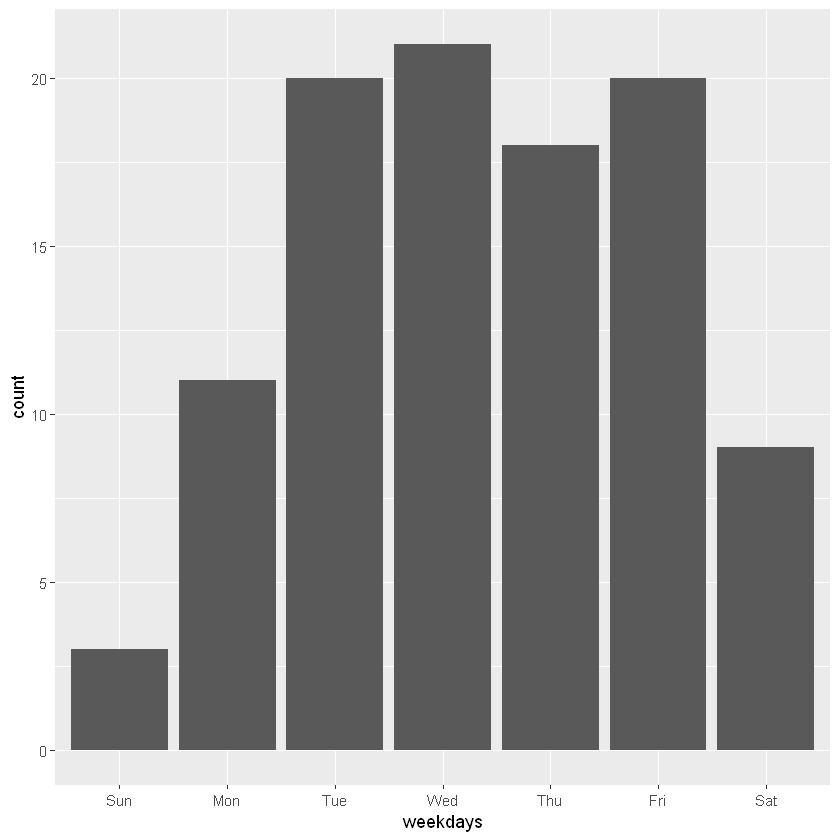

In [60]:
github_count_events_byweekday("repository",102,"WestHealth","pyvis",return_type = "plot")

In [61]:
github_count_events_bytype("repository",102,"WestHealth","pyvis")

type,count
<chr>,<int>
ForkEvent,10
IssueCommentEvent,28
IssuesEvent,14
MemberEvent,1
PullRequestEvent,5
PushEvent,3
WatchEvent,41


In [66]:
sum1 <- github_count_events_bydate("repository",102,"WestHealth","pyvis",event_type = "WatchEvent")

In [65]:
sum2 <- github_count_events_byweekday("repository",102,"WestHealth","pyvis",event_type = "WatchEvent")

In [67]:
sum(sum1[,"count"])

[1] 41

In [68]:
sum(sum2[,"count"])

[1] 41